<a href="https://colab.research.google.com/github/midnightripper/accuracy_improvement/blob/main/VAE_Changing_all_the_Variances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Prerequisite

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Reshape
from tensorflow.keras import backend as K

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Load the train and test data splits

In [4]:
GER_test = (np.array(sio.loadmat('/content/drive/MyDrive/training data/GER_test.mat')['GER_test'])).transpose()
GER_train = (np.array(sio.loadmat('/content/drive/MyDrive/training data/GER_train.mat')['GER_train'])).transpose()
test_frame = pd.DataFrame(GER_test).sort_values(1)
train_frame = pd.DataFrame(GER_train).sort_values(1)

In [5]:
print(f"x_train shape: {GER_train.shape} - y_train shape: {GER_train.shape}")
print(f"x_test shape: {GER_test.shape} - y_test shape: {GER_test.shape}")

x_train shape: (6981, 21) - y_train shape: (6981, 21)
x_test shape: (6248, 21) - y_test shape: (6248, 21)


In [6]:
def get_data_labels(split):
    x = pd.DataFrame(split)
    labels = x[0].values.astype(np.uint8)
    del x[0],x[1]
    data = x.values 
    return data, labels
    
x_train, y_train = get_data_labels(train_frame.values.tolist())
x_test, y_test = get_data_labels(test_frame.values.tolist())

In [7]:
df = pd.DataFrame(x_train)
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [8]:
df2 = pd.DataFrame(x_test)
scaler = StandardScaler()
x_test = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns)

In [9]:
print(x_train.mean())

0     5.699813e-17
1    -1.628518e-17
2     1.791370e-16
3     8.142590e-18
4    -4.071295e-18
5    -4.274860e-16
6    -8.676947e-17
7     8.549719e-17
8     7.302885e-17
9    -4.885554e-17
10    9.771108e-17
11    3.257036e-17
12    1.302814e-16
13    8.386867e-16
14    1.526736e-18
15    2.157786e-16
16    2.015291e-16
17    9.440315e-17
18    8.193481e-17
dtype: float64


In [10]:
print(x_train.std())

0     1.000072
1     1.000072
2     1.000072
3     1.000072
4     1.000072
5     1.000072
6     1.000072
7     1.000072
8     1.000072
9     1.000072
10    1.000072
11    1.000072
12    1.000072
13    1.000072
14    1.000072
15    1.000072
16    1.000072
17    1.000072
18    1.000072
dtype: float64


In [11]:
print(f"Size of the training set: {len(x_train)}")

Size of the training set: 6981


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Size of the x training set: {len(x_train)}")
print(f"Size of the x validation set: {len(x_val)}")
print(f"Size of the y training set: {len(y_train)}")
print(f"Size of the y validation set: {len(y_val)}")

Size of the x training set: 5584
Size of the x validation set: 1397
Size of the y training set: 5584
Size of the y validation set: 1397


In [13]:
print(x_train[:5])
print(y_train[:5])

            0         1         2         3         4         5         6   \
6565 -1.076680 -1.065748 -1.012843 -0.799906 -0.713923 -0.710367 -1.932554   
4003  0.582947  1.135969  1.297658  1.015694  0.868769 -0.130759 -1.806106   
1010 -0.545586 -0.653364 -0.430347 -0.782925 -0.775639 -0.323475 -0.652264   
4617 -0.566326 -0.578170 -0.686170 -0.379677 -0.210357 -1.287966  0.392749   
931   0.245015  0.061639  0.443537 -0.616326 -0.935091  0.915754  0.721268   

            7         8         9         10        11        12        13  \
6565  2.396384 -0.985383 -0.853229 -0.838086 -0.790418 -0.770441  1.082992   
4003  1.601756 -0.026166  1.974222  2.026149  2.399590  2.084844 -0.682288   
1010  0.034567 -1.103360  0.015721  0.285905  0.997402  0.964844 -2.012156   
4617 -0.268374 -0.030353 -0.463698 -0.261271  1.170901  1.321986 -2.641625   
931  -0.828500 -0.803408 -0.062883 -0.065124 -0.179201 -0.313890  0.995570   

            14        15        16        17        18  
6565 

Early stopping to prevent over-fitting

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [27]:
def loss(outputs,inputs,z_log_var,z_mean):
  reconstruction_loss = K.mean(K.square(outputs - inputs), axis=-1)
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  return vae_loss





# Function Calls

In [28]:
input_shape = (19,)

In [43]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.004 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [35]:
inputs = keras.layers.Input(shape=input_shape, name='input')
x = keras.layers.Dense(8, activation='relu')(inputs)
x = keras.layers.Dense(4, activation='relu')(x)
z_mean = keras.layers.Dense(4, name='z_mean')(x)
z_log_var = keras.layers.Dense(4, name='z_log_var')(x)

# Decoder

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history1 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val,x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.5 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history2 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.25 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history3 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.1 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history4 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.05 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history5 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.025 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history6 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.001 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history7 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.00000005 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history8 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

# Initialising Loss 

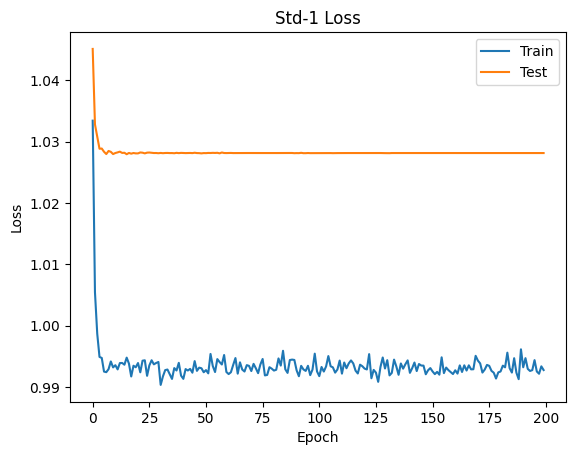

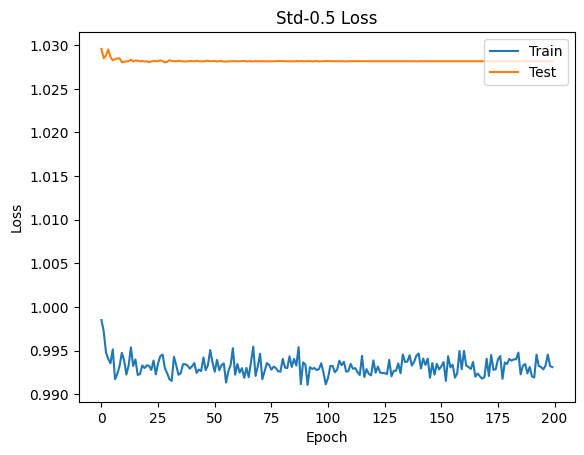

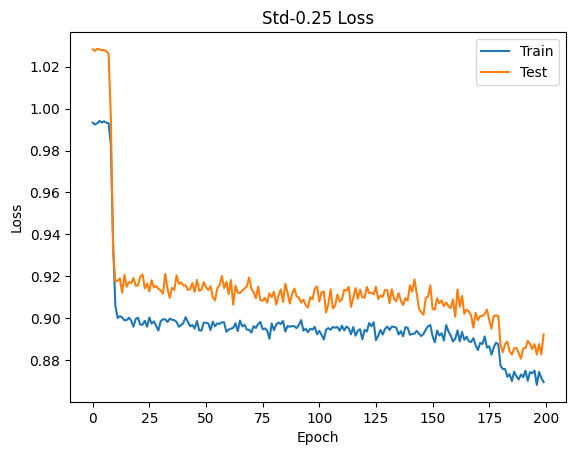

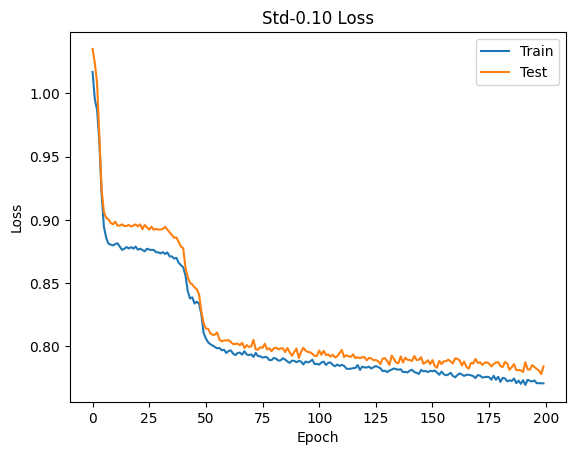

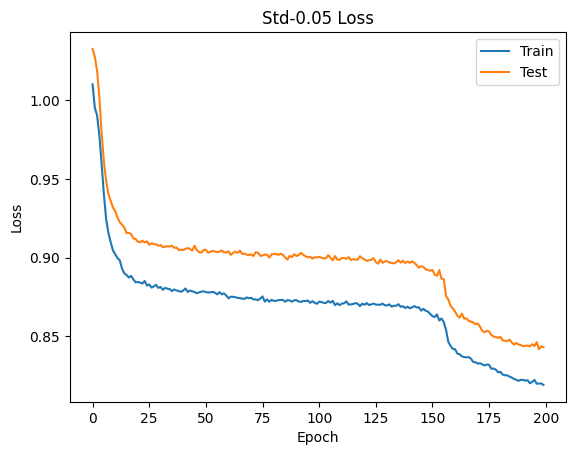

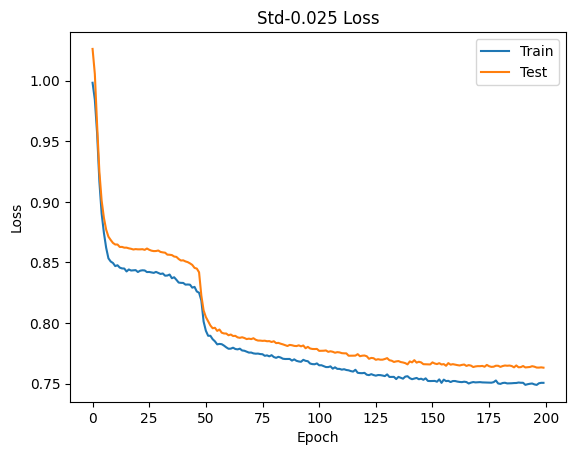

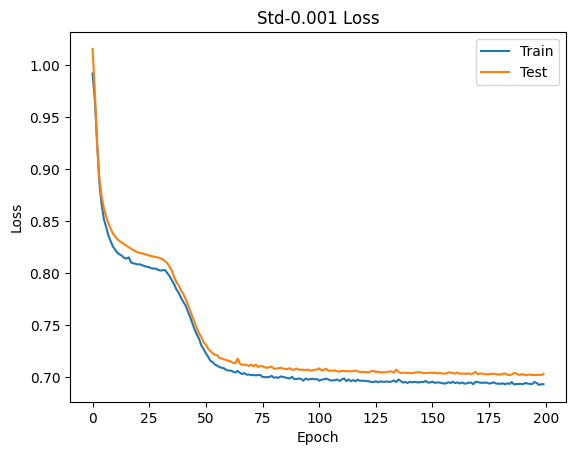

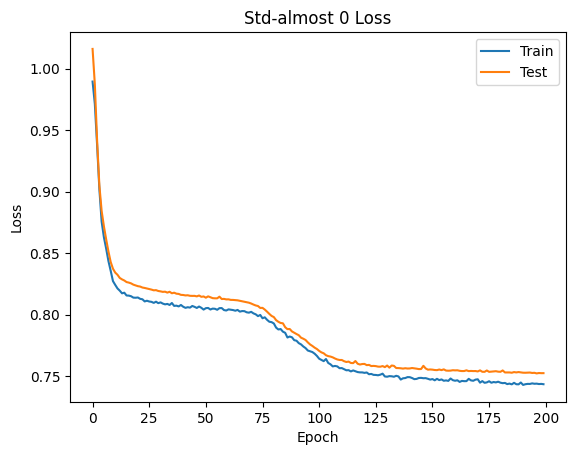

In [81]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Std-1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Std-0.5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Std-0.25 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Std-0.10 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Std-0.05 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Std-0.025 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Std-0.001 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Std-almost 0 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [82]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.01 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history1 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val,x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9882 - val_loss: 1.0148
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9690 - val_loss: 0.9818
Epoch 3/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9321 - val_loss: 0.9407
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 0.9042 - val_loss: 0.9155
Epoch 5/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8850 - val_loss: 0.9016
Epoch 6/200
44/44 [==============================] - 0s 7ms/step - loss: 0.8771 - val_loss: 0.8928
Epoch 7/200
44/44 [==============================] - 0s 7ms/step - loss: 0.8710 - val_loss: 0.8867
Epoch 8/200
44/44 [==============================] - 1s 17ms/step - loss: 0.8646 - val_loss: 0.8820
Epoch 9/200
44/44 [==============================] - 1s 16ms/step - loss: 0.8589 - val_loss: 0.8685
Epoch 10/200
44/44 [==============================] - 0s 11ms/step - loss: 0.8459 - val_loss: 0.8572
Epoch 

In [83]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.008 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history2 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9864 - val_loss: 1.0086
Epoch 2/200
44/44 [==============================] - 0s 7ms/step - loss: 0.9625 - val_loss: 0.9777
Epoch 3/200
44/44 [==============================] - 0s 6ms/step - loss: 0.9284 - val_loss: 0.9398
Epoch 4/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8971 - val_loss: 0.9068
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 0.8712 - val_loss: 0.8830
Epoch 6/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8530 - val_loss: 0.8670
Epoch 7/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8413 - val_loss: 0.8551
Epoch 8/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8312 - val_loss: 0.8461
Epoch 9/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8236 - val_loss: 0.8378
Epoch 10/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8158 - val_loss: 0.8312
Epoch 11/

In [84]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.006 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history3 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9828 - val_loss: 1.0080
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9646 - val_loss: 0.9812
Epoch 3/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9373 - val_loss: 0.9494
Epoch 4/200
44/44 [==============================] - 0s 5ms/step - loss: 0.9124 - val_loss: 0.9246
Epoch 5/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8939 - val_loss: 0.9094
Epoch 6/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8825 - val_loss: 0.8997
Epoch 7/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8762 - val_loss: 0.8933
Epoch 8/200
44/44 [==============================] - 0s 6ms/step - loss: 0.8693 - val_loss: 0.8878
Epoch 9/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8655 - val_loss: 0.8826
Epoch 10/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8606 - val_loss: 0.8783
Epoch 11/

In [85]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.004 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history4 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9856 - val_loss: 1.0051
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9532 - val_loss: 0.9580
Epoch 3/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9135 - val_loss: 0.9193
Epoch 4/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8865 - val_loss: 0.8983
Epoch 5/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8728 - val_loss: 0.8871
Epoch 6/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8650 - val_loss: 0.8805
Epoch 7/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8609 - val_loss: 0.8760
Epoch 8/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8565 - val_loss: 0.8718
Epoch 9/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8528 - val_loss: 0.8680
Epoch 10/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8491 - val_loss: 0.8642
Epoch 11/

In [86]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.002 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history5 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9882 - val_loss: 1.0187
Epoch 2/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9791 - val_loss: 1.0057
Epoch 3/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9661 - val_loss: 0.9893
Epoch 4/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9512 - val_loss: 0.9737
Epoch 5/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9394 - val_loss: 0.9618
Epoch 6/200
44/44 [==============================] - 0s 5ms/step - loss: 0.9310 - val_loss: 0.9525
Epoch 7/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9220 - val_loss: 0.9455
Epoch 8/200
44/44 [==============================] - 0s 5ms/step - loss: 0.9157 - val_loss: 0.9398
Epoch 9/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9108 - val_loss: 0.9362
Epoch 10/200
44/44 [==============================] - 0s 3ms/step - loss: 0.9082 - val_loss: 0.9335
Epoch 11/

In [87]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.001 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history6 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9912 - val_loss: 1.0164
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9723 - val_loss: 0.9862
Epoch 3/200
44/44 [==============================] - 0s 5ms/step - loss: 0.9340 - val_loss: 0.9356
Epoch 4/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8945 - val_loss: 0.8983
Epoch 5/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8682 - val_loss: 0.8714
Epoch 6/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8426 - val_loss: 0.8479
Epoch 7/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8248 - val_loss: 0.8289
Epoch 8/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8121 - val_loss: 0.8174
Epoch 9/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8025 - val_loss: 0.8079
Epoch 10/200
44/44 [==============================] - 0s 3ms/step - loss: 0.7948 - val_loss: 0.7986
Epoch 11/

In [88]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.0005 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history7 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 2s 8ms/step - loss: 0.9894 - val_loss: 1.0164
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9708 - val_loss: 0.9874
Epoch 3/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9393 - val_loss: 0.9425
Epoch 4/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8976 - val_loss: 0.8982
Epoch 5/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8617 - val_loss: 0.8659
Epoch 6/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8392 - val_loss: 0.8458
Epoch 7/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8240 - val_loss: 0.8329
Epoch 8/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8149 - val_loss: 0.8235
Epoch 9/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8080 - val_loss: 0.8167
Epoch 10/200
44/44 [==============================] - 0s 3ms/step - loss: 0.8017 - val_loss: 0.8114
Epoch 11/

In [89]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=0.0001 , name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z


#Giving input to decoder and initialising shape
z = keras.layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#decoder
latent_inputs = keras.layers.Input(shape=(4), name='z_sampling')
x = keras.layers.Dense(4, activation='relu')(latent_inputs)
middle=keras.layers.Dense(8, activation='relu')(x)
x = keras.layers.Dense(19, activation='relu')(middle)

# instantiate decoder model
decoder = keras.Model(latent_inputs, x, name='decoder')
outputs = decoder(encoder(inputs)[2])  # Select the Z value from outputs of the encoder
vae = keras.Model(inputs, outputs, name='vae')

autoencoder = Model(inputs, outputs)
autoencoder.add_loss(loss(outputs,inputs,z_log_var,z_mean))
autoencoder.compile(optimizer='adam')

history8 = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/200
44/44 [==============================] - 3s 9ms/step - loss: 0.9827 - val_loss: 0.9979
Epoch 2/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9470 - val_loss: 0.9525
Epoch 3/200
44/44 [==============================] - 0s 4ms/step - loss: 0.9066 - val_loss: 0.9093
Epoch 4/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8727 - val_loss: 0.8791
Epoch 5/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8523 - val_loss: 0.8610
Epoch 6/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8400 - val_loss: 0.8504
Epoch 7/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8311 - val_loss: 0.8434
Epoch 8/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8272 - val_loss: 0.8393
Epoch 9/200
44/44 [==============================] - 0s 5ms/step - loss: 0.8228 - val_loss: 0.8353
Epoch 10/200
44/44 [==============================] - 0s 4ms/step - loss: 0.8200 - val_loss: 0.8320
Epoch 11/

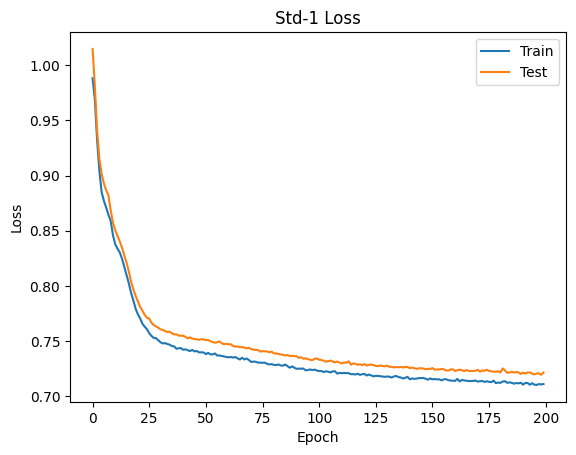

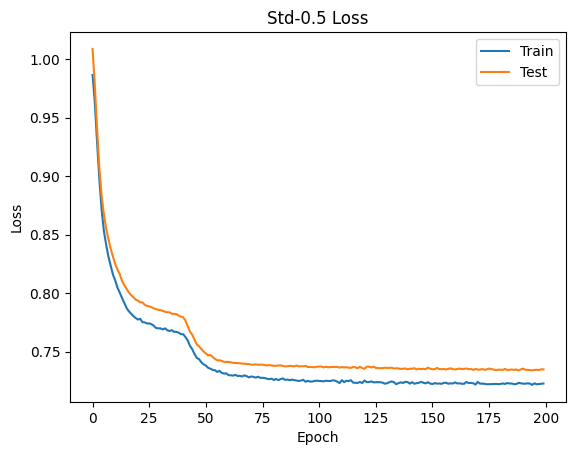

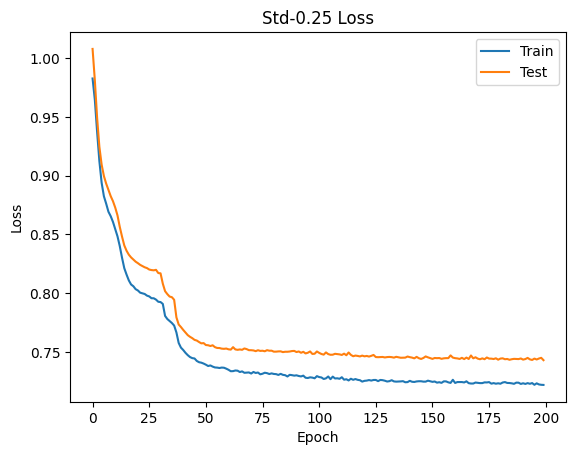

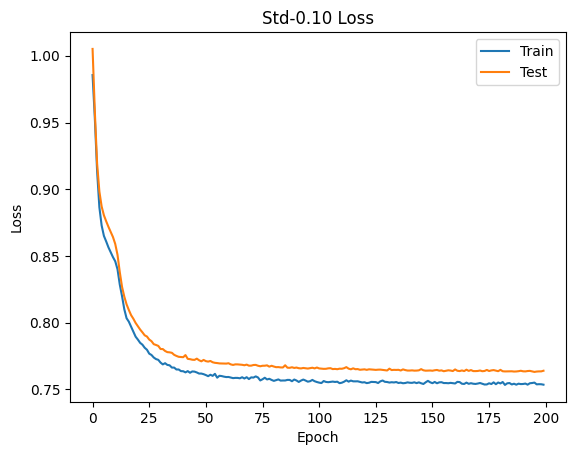

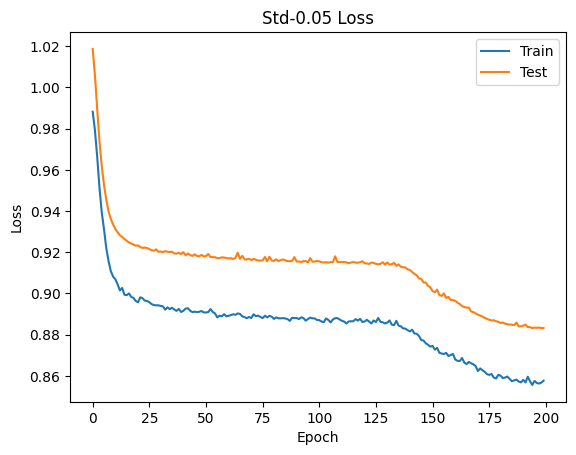

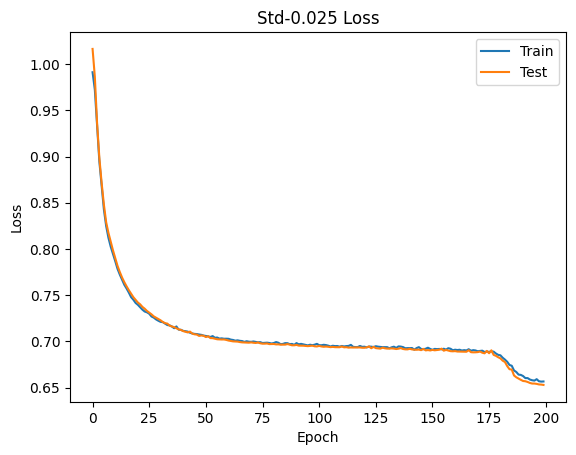

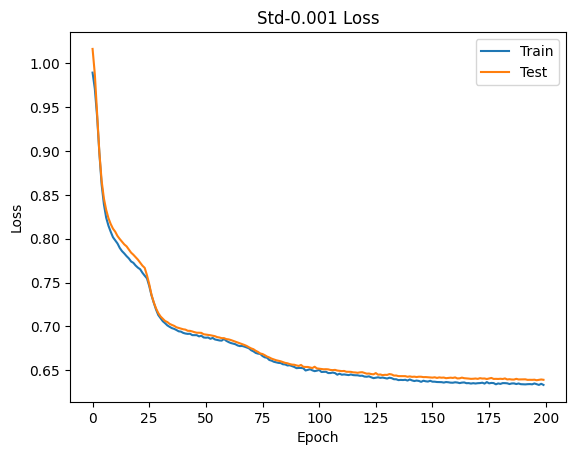

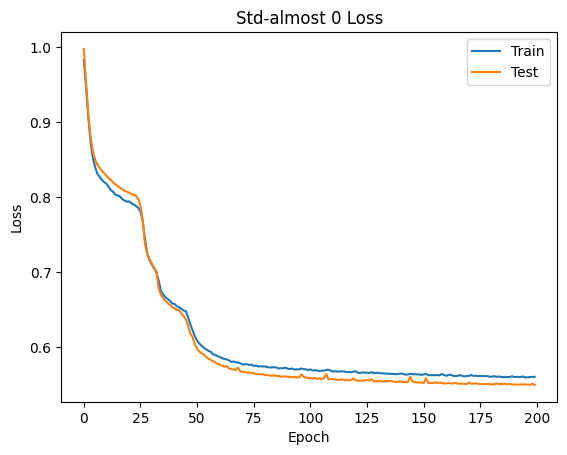

In [90]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Std-1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Std-0.5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Std-0.25 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Std-0.10 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Std-0.05 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Std-0.025 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Std-0.001 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Std-almost 0 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()